<a href="https://colab.research.google.com/github/cgaldston/goodreads_reccomendation/blob/main/two_tower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-surprise --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 126.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2

In [ ]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
import gzip
import json
import random
import math

In [ ]:
BASE_URL = "https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/byGenre"
GENRES = ["poetry", "mystery_thriller_crime"]

In [ ]:
for genre in GENRES:
    print(f"Downloading {genre}...")
    !wget -nc {BASE_URL}/goodreads_interactions_{genre}.json.gz -O interactions_{genre}.json.gz --quiet
    !wget -nc {BASE_URL}/goodreads_books_{genre}.json.gz -O books_{genre}.json.gz --quiet

In [ ]:
def load_data_sampled(filename, sample_rate=0.2, seed=42):
    """
    Random sample while streaming - preserves distribution
    """
    import random
    random.seed(seed)

    data = []
    total_seen = 0

    with gzip.open(filename, 'r') as f:
        for line in f:
            record = json.loads(line.strip())
            total_seen += 1

            # Filter first
            if not record.get("is_read"):
                continue

            # Random sample
            if random.random() > sample_rate:
                continue

            data.append({
                "user_id": record["user_id"],
                "book_id": record["book_id"],
                "rating": record["rating"],
                "is_read": record["is_read"],
            })

            # Progress
            if len(data) % 500_000 == 0:
                print(f"  Sampled {len(data):,} / seen {total_seen:,}")

    print(f"  Final: {len(data):,} sampled from {total_seen:,} ({100*len(data)/total_seen:.1f}%)")
    return pl.DataFrame(data)

def load_meta_data(file_name):
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            data.append(d)

    return data

In [ ]:
# Poetry: full
poetry_interactions = load_data_sampled("interactions_poetry.json.gz", sample_rate=1.0)

# Mystery: 20% random sample
mystery_interactions = load_data_sampled("interactions_mystery_thriller_crime.json.gz", sample_rate=0.2)

# Combine
interactions_df = pl.concat([poetry_interactions, mystery_interactions]).unique(subset=["user_id", "book_id"])

del poetry_interactions, mystery_interactions
import gc
gc.collect()

  Sampled 500,000 / seen 1,045,284
  Sampled 1,000,000 / seen 2,155,224
  Final: 1,313,610 sampled from 2,734,350 (48.0%)
  Sampled 500,000 / seen 4,924,949
  Sampled 1,000,000 / seen 9,990,058
  Sampled 1,500,000 / seen 15,302,854
  Sampled 2,000,000 / seen 20,471,012
  Sampled 2,500,000 / seen 24,757,131
  Final: 2,506,342 sampled from 24,799,896 (10.1%)


0

In [ ]:
interactions_df.head()

user_id,book_id,rating,is_read
str,str,i64,bool
"""d11ee3f98771903f2c5abaea9e18d7…","""275505""",4,true
"""d74794110b1fe69e735094c00287f1…","""6853""",3,true
"""cc91969f0b682e67db1beec2e6731f…","""13183496""",4,true
"""6e1194cb4f9301671c426c155cc20e…","""8008928""",5,true
"""90981174c7a04a0d0cdbceb08a2e64…","""38504""",5,true


In [ ]:
all_books = {}

for genre in GENRES:
    print(f"Loading {genre}...")

    # Load books (dedupe by book_id)
    books = load_meta_data(f"books_{genre}.json.gz")
    for book in books:
        all_books[book["book_id"]] = book  # Later genre overwrites, that's fine
    print(f"  Books: {len(books):,}")


# Dedupe interactions (same user-book pair might appear in both genres)
interactions_df = interactions_df.unique(subset=["user_id", "book_id"])
print(f"Combined interactions (after dedupe): {len(interactions_df):,}")

# Convert books dict to list
meta_data = list(all_books.values())
print(f"Combined books: {len(meta_data):,}")

Loading poetry...
  Books: 36,514
Loading mystery_thriller_crime...
  Books: 219,235
Combined interactions (after dedupe): 3,819,818
Combined books: 255,728


## EDA

In [ ]:
interactions_df.shape

(3819818, 4)

In [ ]:
interactions_df.head()

user_id,book_id,rating,is_read
str,str,i64,bool
"""0bb5a661d332fcbc28d28fb53ef846…","""2547""",5,true
"""d97c49fd07991b015ef3e2b87565ae…","""16130549""",4,true
"""145e07cb26ba21bdc67114a3670559…","""18498558""",0,true
"""cb88d98dd168ab4e733b6ef2b389f2…","""77903""",3,true
"""74a3b60e5a9e819978a915a436a052…","""16156295""",4,true


In [ ]:
def extract_book_features(record):
    def to_int(x):
        try: return int(x)
        except: return None

    def to_float(x):
        try: return float(x)
        except: return None

    shelves = [s["name"] for s in record.get("popular_shelves", [])]
    authors = record.get("authors", [])

    ratings = to_int(record.get("ratings_count") or 0)
    reviews = to_int(record.get("text_reviews_count") or 0)

    return {
        # IDs
        "book_id": record.get("book_id"),

        # Categorical
        "author_ids": [a["author_id"] for a in authors],
        "publisher": record.get("publisher") or None,
        "format": record.get("format") or None,
        "language_code": record.get("language_code") or None,
        "top_shelves": shelves[:5],

        # Numeric (original)
        "average_rating": to_float(record.get("average_rating")),
        "ratings_count_log": math.log1p(ratings),
        "text_reviews_count_log": math.log1p(reviews),
        "num_pages": to_int(record.get("num_pages")),
        "publication_year": to_int(record.get("publication_year")),

        # Numeric (new)
        "num_authors": len(authors),
        "review_ratio": reviews / (ratings + 1),

        # Text
        "title": record.get("title_without_series") or record.get("title"),
        "description": record.get("description") or "",
    }

In [ ]:
processed_books = []

for record in meta_data:
    features = extract_book_features(record)
    processed_books.append(features)

In [ ]:
processed_books_df = pl.DataFrame(processed_books)

In [ ]:
processed_books_df.head()

book_id,author_ids,publisher,format,language_code,top_shelves,average_rating,ratings_count_log,text_reviews_count_log,num_pages,publication_year,num_authors,review_ratio,title,description
str,list[str],str,str,str,list[str],f64,f64,f64,i64,i64,i64,f64,str,str
"""16037549""","[""15585""]","""Houghton, Mifflin and Company""","""Paperback""","""eng""","[""to-read"", ""poetry"", … ""real-books""]",3.83,1.386294,0.693147,80,1887,1,0.25,"""Vision of Sir Launfal and Othe…","""Number 30 in a series of liter…"
"""22466716""","[""16073"", ""3484503"", … ""1028358""]","""New Directions""","""Paperback""",null,"[""to-read"", ""currently-reading"", … ""books-i-own""]",3.83,3.637586,1.098612,128,2015,4,0.052632,"""Fairy Tales: Dramolettes""","""Fairy Tales gathers the unconv…"
"""926662""","[""18540"", ""248155""]","""Farrar Straus Giroux""","""Paperback""",null,"[""to-read"", ""poetry"", … ""illustration""]",4.38,3.828641,2.079442,null,2008,2,0.152174,"""Growltiger's Last Stand and Ot…","""Three poems describe the night…"
"""926667""","[""18540""]","""Mariner Books""","""Paperback""",null,"[""to-read"", ""plays"", … ""fiction""]",3.71,4.75359,2.564949,190,1964,1,0.103448,"""The Cocktail Party""","""A modern verse play about the …"
"""29065952""","[""14308759""]","""ELJ Publications""","""Paperback""","""eng""","[""to-read"", ""poetry"", … ""misc""]",5.0,2.302585,1.609438,118,2015,1,0.4,"""Louder Than Everything You Lov…","""Louder Than Everything You Lov…"


In [ ]:
# 1. Missing values
processed_books_df.null_count()

book_id,author_ids,publisher,format,language_code,top_shelves,average_rating,ratings_count_log,text_reviews_count_log,num_pages,publication_year,num_authors,review_ratio,title,description
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,63962,63864,101908,0,0,0,0,77326,60305,0,0,0,0


In [ ]:
processed_books_df = processed_books_df.filter(
    (pl.col("num_pages") < 10000) &
    (pl.col("publication_year") < 2026) &
    (pl.col("publication_year") > 1000)
)

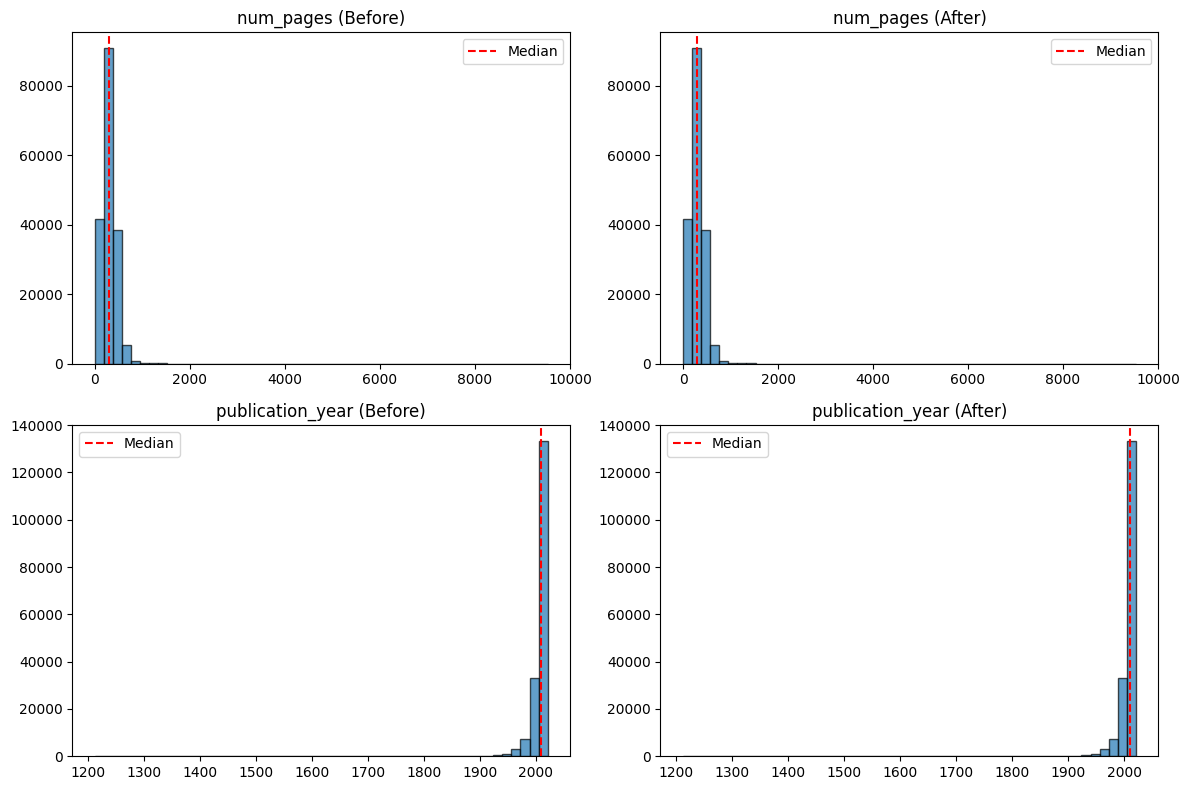

num_pages - Before std: 168.9, After std: 168.9
pub_year - Before std: 16.2, After std: 16.2


In [ ]:
# Examine how mean imputation affects distributions
num_pages_before = processed_books_df["num_pages"].drop_nulls().to_numpy()
pub_year_before = processed_books_df["publication_year"].drop_nulls().to_numpy()

# Impute
processed_books_df = processed_books_df.with_columns([
    pl.col("num_pages").fill_null(pl.col("num_pages").median()),
    pl.col("publication_year").fill_null(pl.col("publication_year").median()),
])

# After imputation
num_pages_after = processed_books_df["num_pages"].to_numpy()
pub_year_after = processed_books_df["publication_year"].to_numpy()

# Plot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].hist(num_pages_before, bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].set_title("num_pages (Before)")
axes[0, 0].axvline(x=np.median(num_pages_before), color='red', linestyle='--', label='Median')

axes[0, 1].hist(num_pages_after, bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_title("num_pages (After)")
axes[0, 1].axvline(x=np.median(num_pages_after), color='red', linestyle='--', label='Median')

axes[1, 0].hist(pub_year_before, bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].set_title("publication_year (Before)")
axes[1, 0].axvline(x=np.median(pub_year_before), color='red', linestyle='--', label='Median')

axes[1, 1].hist(pub_year_after, bins=50, alpha=0.7, edgecolor='black')
axes[1, 1].set_title("publication_year (After)")
axes[1, 1].axvline(x=np.median(pub_year_after), color='red', linestyle='--', label='Median')

for ax in axes.flat:
    ax.legend()

plt.tight_layout()
plt.show()

# Print stats
print(f"num_pages - Before std: {num_pages_before.std():.1f}, After std: {num_pages_after.std():.1f}")
print(f"pub_year - Before std: {pub_year_before.std():.1f}, After std: {pub_year_after.std():.1f}")

In [ ]:
# Get book_ids with nulls (before imputation)
books_with_null_pages = processed_books_df.filter(
    pl.col("num_pages").is_null()
)["book_id"].to_list()

books_with_null_year = processed_books_df.filter(
    pl.col("publication_year").is_null()
)["book_id"].to_list()

In [ ]:
processed_books_df = processed_books_df.with_columns([
    pl.col("publisher").fill_null("Unknown"),
    pl.col("format").fill_null("Unknown"),
    pl.col("language_code").fill_null("Unknown"),
])

processed_books_df = processed_books_df.with_columns([
    pl.col("num_pages").fill_null(pl.col("num_pages").median()),
    pl.col("publication_year").fill_null(pl.col("publication_year").median()),
])

processed_books_df = processed_books_df.drop("language_code")

In [ ]:
processed_books_df.describe()

statistic,book_id,author_ids,publisher,format,top_shelves,average_rating,ratings_count_log,text_reviews_count_log,num_pages,publication_year,num_authors,review_ratio,title,description
str,str,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str
"""count""","""178309""",178309.0,"""178309""","""178309""",178309.0,178309.0,178309.0,178309.0,178309.0,178309.0,178309.0,178309.0,"""178309""","""178309"""
"""null_count""","""0""",0.0,"""0""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""0""","""0"""
"""mean""",null,null,null,null,null,3.853928,3.824047,2.251452,295.868358,2006.492858,1.354974,0.220068,null,null
"""std""",null,null,null,null,null,0.348604,1.827212,1.324652,168.913957,16.15328,1.519314,0.16758,null,null
"""min""","""10000063""",null,"""""De Facto""""","""(Paperback)""",null,0.0,0.0,0.0,0.0,1213.0,1.0,0.0,"""""",""""""
"""25%""",null,null,null,null,null,3.66,2.564949,1.098612,196.0,2004.0,1.0,0.1,null,null
"""50%""",null,null,null,null,null,3.87,3.610918,1.94591,296.0,2010.0,1.0,0.172632,null,null
"""75%""",null,null,null,null,null,4.07,4.867534,2.944439,384.0,2013.0,1.0,0.288136,null,null
"""max""","""9999742""",null,"""zwarte beertjes""","""zine""",null,5.0,14.531642,11.270077,9532.0,2021.0,80.0,2.0,"""스노우맨""","""Vi kien truc su tai hoa nam n…"


In [ ]:
# 3. Categorical cardinality
print(f"Unique publishers: {processed_books_df['publisher'].n_unique()}")
print(f"Unique formats: {processed_books_df['format'].n_unique()}")

Unique publishers: 23913
Unique formats: 339


In [ ]:
from collections import Counter
all_shelves = [s for shelves in processed_books_df["top_shelves"].to_list() for s in (shelves or [])]
print(Counter(all_shelves).most_common(20))

[('to-read', 173930), ('currently-reading', 110416), ('mystery', 93563), ('fiction', 71725), ('thriller', 34148), ('crime', 27725), ('poetry', 26746), ('kindle', 16021), ('favorites', 14773), ('mysteries', 11517), ('horror', 9546), ('historical-fiction', 7949), ('default', 7897), ('classics', 7404), ('owned', 6709), ('romance', 5851), ('cozy-mystery', 5812), ('non-fiction', 5457), ('young-adult', 5443), ('series', 5032)]


<Axes: >

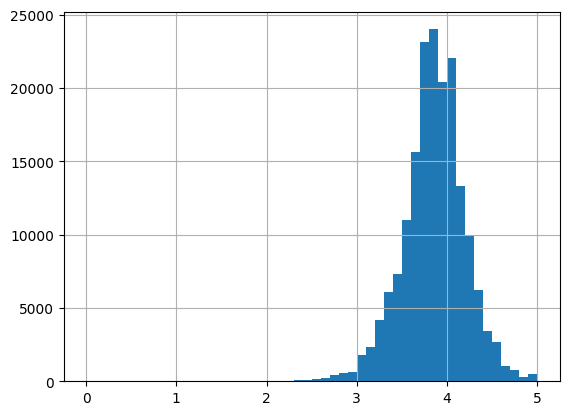

In [ ]:
processed_books_df["average_rating"].to_pandas().hist(bins=50)

In [ ]:
def create_user_features(interactions_df: pl.DataFrame) -> pl.DataFrame:
    """Aggregate user-level features from interactions"""

    user_features = interactions_df.group_by("user_id").agg([
        # Reading volume
        pl.len().alias("num_books"),

        # Rating behavior
        pl.col("rating").mean().alias("avg_rating_given"),
        pl.col("rating").std().alias("rating_std"),
        pl.col("rating").min().alias("min_rating"),
        pl.col("rating").max().alias("max_rating"),
    ])


    return user_features

In [ ]:
MIN_INTERACTIONS = 3

# Filter users
active_users = (
    interactions_df
    .group_by("user_id")
    .agg(pl.len().alias("n"))
    .filter(pl.col("n") >= MIN_INTERACTIONS)
    ["user_id"]
    .to_list()
)

# Filter interactions for training
train_interactions = interactions_df.filter(
    pl.col("user_id").is_in(active_users)
)

In [ ]:
MIN_BOOK_INTERACTIONS = 3

active_books = (
    interactions_df
    .group_by("book_id")
    .agg(pl.len().alias("n"))
    .filter(pl.col("n") >= MIN_BOOK_INTERACTIONS)
    ["book_id"]
    .to_list()
)

train_interactions = train_interactions.filter(
    pl.col("book_id").is_in(active_books)
)

In [ ]:
print(f"Original interactions: {len(interactions_df):,}")
print(f"After filtering: {len(train_interactions):,}")
print(f"Users remaining: {train_interactions['user_id'].n_unique():,}")

Original interactions: 3,819,818
After filtering: 3,416,436
Users remaining: 294,203


In [ ]:
train_interactions = train_interactions.filter(pl.col("rating") > 0)

print(f"After removing 0 ratings: {len(train_interactions):,}")
print(train_interactions["rating"].value_counts().sort("rating"))

After removing 0 ratings: 3,209,632
shape: (5, 2)
┌────────┬─────────┐
│ rating ┆ count   │
│ ---    ┆ ---     │
│ i64    ┆ u32     │
╞════════╪═════════╡
│ 1      ┆ 52093   │
│ 2      ┆ 182067  │
│ 3      ┆ 757966  │
│ 4      ┆ 1199306 │
│ 5      ┆ 1018200 │
└────────┴─────────┘


In [ ]:
user_features_df = create_user_features(train_interactions)
user_features_df.head()

user_id,num_books,avg_rating_given,rating_std,min_rating,max_rating
str,u32,f64,f64,i64,i64
"""94d821715f06eee8786012fd6afa18…",4,4.25,0.5,4,5
"""0775932cb6104e44b7befdae77e134…",4,4.25,0.957427,3,5
"""070a6a84bc7e0b2881fa19f4630c34…",7,4.857143,0.377964,4,5
"""50618e93a335bbae6362ad185871de…",16,3.75,0.774597,3,5
"""a3cbe439a39eebb5d69be02e441bc0…",27,4.703704,0.608581,3,5


## Prepare Data for models

In [ ]:
# Data preprocessing

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from typing import Dict, List, Tuple

class FeatureEncoder:
    """Encodes categorical features to indices"""
    def __init__(self):
        self.user_to_idx = {}
        self.book_to_idx = {}
        self.author_to_idx = {}
        self.publisher_to_idx = {}
        self.format_to_idx = {}
        self.shelf_to_idx = {}

    def fit(self, interactions_df: pl.DataFrame, metadata_df: pl.DataFrame):
        # Users
        users = interactions_df["user_id"].unique().to_list()
        self.user_to_idx = {u: i for i, u in enumerate(users)}

        # Books
        books = metadata_df["book_id"].unique().to_list()
        self.book_to_idx = {b: i for i, b in enumerate(books)}

        # Authors (flatten list column)
        all_authors = set()
        for authors in metadata_df["author_ids"].to_list():
            if authors:
                all_authors.update(authors)
        self.author_to_idx = {a: i for i, a in enumerate(all_authors)}
        self.author_to_idx["<UNK>"] = len(self.author_to_idx)

        # Publishers
        publishers = metadata_df["publisher"].unique().to_list()
        self.publisher_to_idx = {p: i for i, p in enumerate(publishers) if p}
        self.publisher_to_idx["<UNK>"] = len(self.publisher_to_idx)

        # Formats
        formats = metadata_df["format"].unique().to_list()
        self.format_to_idx = {f: i for i, f in enumerate(formats) if f}
        self.format_to_idx["<UNK>"] = len(self.format_to_idx)

        # Shelves (flatten list column)
        all_shelves = set()
        for shelves in metadata_df["top_shelves"].to_list():
            if shelves:
                all_shelves.update(shelves)
        self.shelf_to_idx = {s: i for i, s in enumerate(all_shelves)}
        self.shelf_to_idx["<UNK>"] = len(self.shelf_to_idx)

        return self

    @property
    def num_users(self): return len(self.user_to_idx)

    @property
    def num_books(self): return len(self.book_to_idx)

    @property
    def num_authors(self): return len(self.author_to_idx)

    @property
    def num_publishers(self): return len(self.publisher_to_idx)

    @property
    def num_formats(self): return len(self.format_to_idx)

    @property
    def num_shelves(self): return len(self.shelf_to_idx)

In [ ]:
class GoodreadsDataset(Dataset):
    def __init__(
        self,
        interactions_df: pl.DataFrame,
        metadata_df: pl.DataFrame,
        encoder: FeatureEncoder,
        numerical_cols: List[str] = [
            "average_rating",
            "ratings_count_log",
            "text_reviews_count_log",
            "num_pages",
            "publication_year",
            "num_authors",
            "review_ratio"
        ]
    ):
        self.encoder = encoder
        self.numerical_cols = numerical_cols

        # Merge interactions with metadata
        self.data = interactions_df.join(metadata_df, on="book_id", how="inner")
        self.data = self.data.join(user_features_df, on="user_id", how="left")

        # Compute normalization stats for numerical features
        self.num_means = {}
        self.num_stds = {}
        for col in numerical_cols:
            values = self.data[col].drop_nulls().to_numpy()
            self.num_means[col] = np.nanmean(values)
            self.num_stds[col] = np.nanstd(values) + 1e-8

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.row(idx, named=True)

        # User features
        user_idx = self.encoder.user_to_idx.get(row["user_id"], 0)
        user_feature_cols = ["num_books", "avg_rating_given", "rating_std", "min_rating", "max_rating"]
        user_feats = [row[col] or 0 for col in user_feature_cols]

        # Book features
        book_idx = self.encoder.book_to_idx.get(row["book_id"], 0)

        # Authors (list -> indices)
        authors = row["author_ids"] or []
        author_indices = [self.encoder.author_to_idx.get(a, self.encoder.author_to_idx["<UNK>"])
                         for a in authors]
        if not author_indices:
            author_indices = [self.encoder.author_to_idx["<UNK>"]]

        # Other categorical features
        publisher_idx = self.encoder.publisher_to_idx.get(
            row["publisher"], self.encoder.publisher_to_idx["<UNK>"])
        format_idx = self.encoder.format_to_idx.get(
            row["format"], self.encoder.format_to_idx["<UNK>"])

        # Shelves (list -> indices)
        shelves = row["top_shelves"] or []
        shelf_indices = [self.encoder.shelf_to_idx.get(s, self.encoder.shelf_to_idx["<UNK>"])
                        for s in shelves]
        if not shelf_indices:
            shelf_indices = [self.encoder.shelf_to_idx["<UNK>"]]

        # Numerical features (normalized)
        numerical = []
        for col in self.numerical_cols:
            val = row[col]
            if val is None or np.isnan(val):
                val = self.num_means[col]
            numerical.append((val - self.num_means[col]) / self.num_stds[col])

        # Target (rating)
        rating = row["rating"] / 5.0  # Normalize to [0, 1]

        return {
            "user_idx": user_idx,
            "user_features": user_feats,
            "book_idx": book_idx,
            "author_indices": author_indices,
            "publisher_idx": publisher_idx,
            "format_idx": format_idx,
            "shelf_indices": shelf_indices,
            "numerical": numerical,
            "rating": rating
        }

def collate_fn(batch):
    """Custom collate function to handle variable-length lists"""
    user_idx = torch.tensor([b["user_idx"] for b in batch], dtype=torch.long)
    book_idx = torch.tensor([b["book_idx"] for b in batch], dtype=torch.long)
    publisher_idx = torch.tensor([b["publisher_idx"] for b in batch], dtype=torch.long)
    format_idx = torch.tensor([b["format_idx"] for b in batch], dtype=torch.long)
    numerical = torch.tensor([b["numerical"] for b in batch], dtype=torch.float32)
    rating = torch.tensor([b["rating"] for b in batch], dtype=torch.float32)
    user_features = torch.tensor([b["user_features"] for b in batch], dtype=torch.float32)

    # Handle variable-length author lists with EmbeddingBag format
    author_indices = []
    author_offsets = [0]
    for b in batch:
        author_indices.extend(b["author_indices"])
        author_offsets.append(len(author_indices))
    author_indices = torch.tensor(author_indices, dtype=torch.long)
    author_offsets = torch.tensor(author_offsets[:-1], dtype=torch.long)

    # Handle variable-length shelf lists
    shelf_indices = []
    shelf_offsets = [0]
    for b in batch:
        shelf_indices.extend(b["shelf_indices"])
        shelf_offsets.append(len(shelf_indices))
    shelf_indices = torch.tensor(shelf_indices, dtype=torch.long)
    shelf_offsets = torch.tensor(shelf_offsets[:-1], dtype=torch.long)

    return {
        "user_idx": user_idx,
        "book_idx": book_idx,
        "user_features": user_features,
        "author_indices": author_indices,
        "author_offsets": author_offsets,
        "publisher_idx": publisher_idx,
        "format_idx": format_idx,
        "shelf_indices": shelf_indices,
        "shelf_offsets": shelf_offsets,
        "numerical": numerical,
        "rating": rating
    }

## Models

In [ ]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

def train_svd_baseline(interactions_df: pl.DataFrame):
    # Prepare data for Surprise (needs user, item, rating)
    df = interactions_df.select(["user_id", "book_id", "rating"]).to_pandas()

    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(df, reader)

    # Train/test split
    trainset, testset = train_test_split(data, test_size=0.1, random_state=42)

    # Train SVD
    model = SVD(n_factors=64, n_epochs=20, lr_all=0.005, reg_all=0.02, verbose=True)
    model.fit(trainset)

    # Evaluate
    predictions = model.test(testset)
    rmse = accuracy.rmse(predictions)
    mae = accuracy.mae(predictions)

    # Get prediction stats
    preds = [p.est for p in predictions]
    actuals = [p.r_ui for p in predictions]

    print(f"\n{'='*50}")
    print("SVD BASELINE RESULTS")
    print(f"{'='*50}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"Pred std:   {np.std(preds):.2f}")
    print(f"Actual std: {np.std(actuals):.2f}")

    return model, predictions

svd_model, svd_predictions = train_svd_baseline(train_interactions)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.12/dist-package

ImportError: numpy.core.multiarray failed to import (auto-generated because you didn't call 'numpy.import_array()' after cimporting numpy; use '<void>numpy._import_array' to disable if you are certain you don't need it).

In [ ]:
class UserTower(nn.Module):
    def __init__(
        self,
        num_users: int,
        num_user_features: int = 5,  # NEW
        embedding_dim: int = 64,
        output_dim: int = 64
    ):
        super().__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_dim)

        total_dim = embedding_dim + num_user_features  # NEW

        self.mlp = nn.Sequential(
            nn.Linear(total_dim, 128),  # Updated input dim
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, output_dim),
            nn.ReLU(),
        )

    def forward(self, user_idx: torch.Tensor, user_features: torch.Tensor) -> torch.Tensor:
        user_emb = self.user_embedding(user_idx)
        combined = torch.cat([user_emb, user_features], dim=1)  # NEW
        return self.mlp(combined)

In [ ]:
class BookTower(nn.Module):
    def __init__(
        self,
        num_books: int,
        num_authors: int,
        num_publishers: int,
        num_formats: int,
        num_shelves: int,
        num_numerical: int = 5,
        embedding_dim: int = 64,
        output_dim: int = 64
    ):
        super().__init__()

        # Embeddings for categorical features
        self.book_embedding = nn.Embedding(num_books, embedding_dim)
        self.author_embedding = nn.EmbeddingBag(num_authors, embedding_dim, mode='mean')
        self.publisher_embedding = nn.Embedding(num_publishers, embedding_dim // 4)
        self.format_embedding = nn.Embedding(num_formats, embedding_dim // 4)
        self.shelf_embedding = nn.EmbeddingBag(num_shelves, embedding_dim // 2, mode='mean')

        # Total dimension calculation
        total_dim = (
            embedding_dim +        # book
            embedding_dim +        # authors
            embedding_dim // 4 +   # publisher
            embedding_dim // 4 +   # format
            embedding_dim // 2 +   # shelves
            num_numerical          # numerical features
        )

        self.mlp = nn.Sequential(
            nn.Linear(total_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, output_dim),
            nn.ReLU(),
        )

    def forward(
        self,
        book_idx: torch.Tensor,
        author_indices: torch.Tensor,
        author_offsets: torch.Tensor,
        publisher_idx: torch.Tensor,
        format_idx: torch.Tensor,
        shelf_indices: torch.Tensor,
        shelf_offsets: torch.Tensor,
        numerical: torch.Tensor
    ) -> torch.Tensor:

        book_emb = self.book_embedding(book_idx)
        author_emb = self.author_embedding(author_indices, author_offsets)
        publisher_emb = self.publisher_embedding(publisher_idx)
        format_emb = self.format_embedding(format_idx)
        shelf_emb = self.shelf_embedding(shelf_indices, shelf_offsets)

        combined = torch.cat([
            book_emb, author_emb, publisher_emb,
            format_emb, shelf_emb, numerical
        ], dim=1)

        return self.mlp(combined)

In [ ]:
class TwoTowerModel(nn.Module):
    def __init__(self, user_tower: UserTower, book_tower: BookTower, output_dim: int = 64):
        super().__init__()
        self.user_tower = user_tower
        self.book_tower = book_tower

    def forward(self, batch: Dict[str, torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # Get embeddings from both towers
        user_emb = self.user_tower(batch["user_idx"], batch["user_features"])

        book_emb = self.book_tower(
            batch["book_idx"],
            batch["author_indices"],
            batch["author_offsets"],
            batch["publisher_idx"],
            batch["format_idx"],
            batch["shelf_indices"],
            batch["shelf_offsets"],
            batch["numerical"]
        )

        # L2 normalize embeddings
        user_emb = F.normalize(user_emb, p=2, dim=1)
        book_emb = F.normalize(book_emb, p=2, dim=1)

        # Compute similarity (dot product)
        similarity = torch.sum(user_emb * book_emb, dim=1)

        return similarity, user_emb, book_emb

In [ ]:
from sklearn.model_selection import train_test_split

def split_data(interactions_df: pl.DataFrame, val_size=0.1, test_size=0.1, seed=42):
    """Split interactions into train/val/test"""

    # Convert to pandas for sklearn, then back
    df = interactions_df.to_pandas()

    # First split: train+val vs test
    train_val, test = train_test_split(df, test_size=test_size, random_state=seed)

    # Second split: train vs val
    val_ratio = val_size / (1 - test_size)
    train, val = train_test_split(train_val, test_size=val_ratio, random_state=seed)

    print(f"Train: {len(train):,} ({100*len(train)/len(df):.1f}%)")
    print(f"Val:   {len(val):,} ({100*len(val)/len(df):.1f}%)")
    print(f"Test:  {len(test):,} ({100*len(test)/len(df):.1f}%)")

    return pl.DataFrame(train), pl.DataFrame(val), pl.DataFrame(test)

# Usage
train_df, val_df, test_df = split_data(train_interactions)

Train: 2,567,704 (80.0%)
Val:   320,964 (10.0%)
Test:  320,964 (10.0%)


In [ ]:
from tqdm import tqdm

def weighted_mse_loss(pred, target):
    # Higher weight for 1s and 5s (extremes)
    weights = 1 + torch.abs(target - 0.6) * 2  # 0.6 ≈ rating 3 normalized
    return (weights * (pred - target) ** 2).mean()

def train_model(
    train_df: pl.DataFrame,
    val_df: pl.DataFrame,
    metadata_df: pl.DataFrame,
    epochs: int = 20,
    batch_size: int = 256,
    lr: float = 1e-3,
    embedding_dim: int = 64,
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
):

    encoder = FeatureEncoder().fit(train_df, metadata_df)

    train_dataset = GoodreadsDataset(train_df, metadata_df, encoder)
    val_dataset = GoodreadsDataset(val_df, metadata_df, encoder)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    user_tower = UserTower(num_users=encoder.num_users, embedding_dim=embedding_dim)
    book_tower = BookTower(
        num_books=encoder.num_books,
        num_authors=encoder.num_authors,
        num_publishers=encoder.num_publishers,
        num_formats=encoder.num_formats,
        num_shelves=encoder.num_shelves,
        num_numerical=len(train_dataset.numerical_cols)
    )

    model = TwoTowerModel(user_tower, book_tower).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Train
        model.train()
        total_train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            similarity, _, _ = model(batch)
            pred = (similarity + 1) / 2
            loss = weighted_mse_loss(pred, batch["rating"])
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        # Validate
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                similarity, _, _ = model(batch)
                pred = (similarity + 1) / 2
                loss = weighted_mse_loss(pred, batch["rating"])
                total_val_loss += loss.item()

        train_loss = total_train_loss / len(train_loader)
        val_loss = total_val_loss / len(val_loader)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training vs Validation Loss")
    plt.grid(True)
    plt.show()

    return model, encoder, train_losses, val_losses

Train: 2,567,704 (80.0%)
Val:   320,964 (10.0%)
Test:  320,964 (10.0%)


Epoch 1 [Train]: 100%|██████████| 9082/9082 [03:52<00:00, 39.05it/s]


Epoch 1: Train Loss=0.0362, Val Loss=0.0344


Epoch 2 [Train]: 100%|██████████| 9082/9082 [03:50<00:00, 39.37it/s]


Epoch 2: Train Loss=0.0345, Val Loss=0.0341


Epoch 3 [Train]: 100%|██████████| 9082/9082 [03:51<00:00, 39.20it/s]


Epoch 3: Train Loss=0.0340, Val Loss=0.0342


Epoch 4 [Train]: 100%|██████████| 9082/9082 [03:52<00:00, 39.03it/s]


Epoch 4: Train Loss=0.0335, Val Loss=0.0344


Epoch 5 [Train]: 100%|██████████| 9082/9082 [03:50<00:00, 39.34it/s]


Epoch 5: Train Loss=0.0328, Val Loss=0.0350


Epoch 6 [Train]: 100%|██████████| 9082/9082 [03:50<00:00, 39.48it/s]


Epoch 6: Train Loss=0.0319, Val Loss=0.0355


Epoch 7 [Train]: 100%|██████████| 9082/9082 [03:53<00:00, 38.84it/s]


Epoch 7: Train Loss=0.0310, Val Loss=0.0360


Epoch 8 [Train]: 100%|██████████| 9082/9082 [03:52<00:00, 39.13it/s]


Epoch 8: Train Loss=0.0301, Val Loss=0.0367


Epoch 9 [Train]: 100%|██████████| 9082/9082 [03:50<00:00, 39.36it/s]


Epoch 9: Train Loss=0.0292, Val Loss=0.0374


Epoch 10 [Train]: 100%|██████████| 9082/9082 [03:49<00:00, 39.58it/s]


Epoch 10: Train Loss=0.0285, Val Loss=0.0379


Epoch 11 [Train]: 100%|██████████| 9082/9082 [03:50<00:00, 39.40it/s]


Epoch 11: Train Loss=0.0278, Val Loss=0.0384


Epoch 12 [Train]: 100%|██████████| 9082/9082 [03:50<00:00, 39.47it/s]


Epoch 12: Train Loss=0.0273, Val Loss=0.0388


Epoch 13 [Train]: 100%|██████████| 9082/9082 [03:49<00:00, 39.54it/s]


Epoch 13: Train Loss=0.0268, Val Loss=0.0392


Epoch 14 [Train]: 100%|██████████| 9082/9082 [03:48<00:00, 39.82it/s]


Epoch 14: Train Loss=0.0263, Val Loss=0.0395


Epoch 15 [Train]: 100%|██████████| 9082/9082 [03:43<00:00, 40.64it/s]


Epoch 15: Train Loss=0.0260, Val Loss=0.0398


Epoch 16 [Train]: 100%|██████████| 9082/9082 [03:45<00:00, 40.33it/s]


Epoch 16: Train Loss=0.0256, Val Loss=0.0401


Epoch 17 [Train]: 100%|██████████| 9082/9082 [03:43<00:00, 40.63it/s]


Epoch 17: Train Loss=0.0253, Val Loss=0.0402


Epoch 18 [Train]: 100%|██████████| 9082/9082 [03:43<00:00, 40.57it/s]


Epoch 18: Train Loss=0.0251, Val Loss=0.0405


Epoch 19 [Train]: 100%|██████████| 9082/9082 [03:43<00:00, 40.72it/s]


Epoch 19: Train Loss=0.0248, Val Loss=0.0407


Epoch 20 [Train]: 100%|██████████| 9082/9082 [03:43<00:00, 40.64it/s]


Epoch 20: Train Loss=0.0246, Val Loss=0.0409


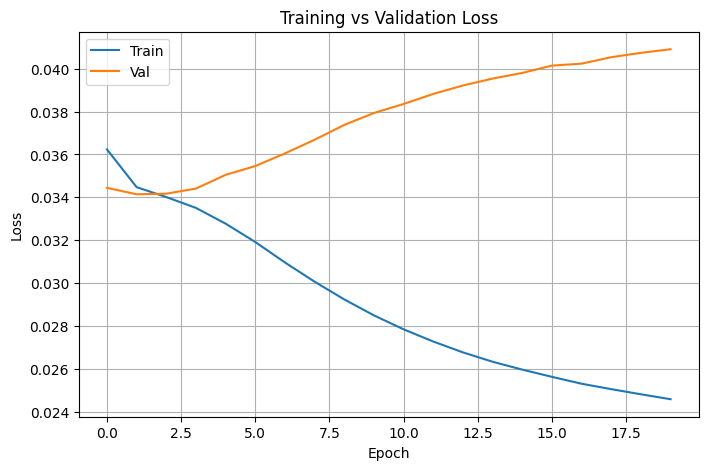

In [ ]:
# Usage
train_df, val_df, test_df = split_data(train_interactions)
model, encoder, train_losses, val_losses = train_model(
    train_df, val_df, processed_books_df
)

In [ ]:
import pickle

# Save model weights
torch.save(model.state_dict(), 'two_tower_model.pt')

# Save encoder (needed to map IDs to indices)
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)

print("Model and encoder saved!")

Model and encoder saved!


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

def evaluate_model(
    model: TwoTowerModel,
    interactions_df: pl.DataFrame,
    metadata_df: pl.DataFrame,
    encoder: FeatureEncoder,
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
):
    """Compute evaluation metrics on the data"""
    model.eval()

    dataset = GoodreadsDataset(interactions_df, metadata_df, encoder)
    dataloader = DataLoader(dataset, batch_size=512, shuffle=False, collate_fn=collate_fn)

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            similarity, _, _ = model(batch)
            predicted_rating = (similarity + 1) / 2

            all_preds.extend(predicted_rating.cpu().numpy())
            all_targets.extend(batch["rating"].cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Convert back to 1-5 scale for interpretability
    preds_scaled = all_preds * 5
    targets_scaled = all_targets * 5

    # Metrics
    mse = np.mean((preds_scaled - targets_scaled) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(preds_scaled - targets_scaled))

    print(f"\n{'='*50}")
    print(f"EVALUATION RESULTS")
    print(f"{'='*50}")
    print(f"RMSE: {rmse:.4f} (on 1-5 scale)")
    print(f"MAE:  {mae:.4f} (on 1-5 scale)")
    print(f"{'='*50}")

    # Distribution of predictions vs actuals
    print(f"\nPrediction Stats:")
    print(f"  Mean predicted: {preds_scaled.mean():.2f}")
    print(f"  Mean actual:    {targets_scaled.mean():.2f}")
    print(f"  Pred std:       {preds_scaled.std():.2f}")
    print(f"  Actual std:     {targets_scaled.std():.2f}")

    return {"rmse": rmse, "mae": mae, "predictions": preds_scaled, "targets": targets_scaled}

In [ ]:
# Run evaluation
results = evaluate_model(model, test_df, processed_books_df, encoder)

Evaluating: 100%|██████████| 568/568 [00:08<00:00, 65.30it/s]


EVALUATION RESULTS
RMSE: 0.8340 (on 1-5 scale)
MAE:  0.6447 (on 1-5 scale)

Prediction Stats:
  Mean predicted: 3.96
  Mean actual:    3.92
  Pred std:       0.63
  Actual std:     0.96


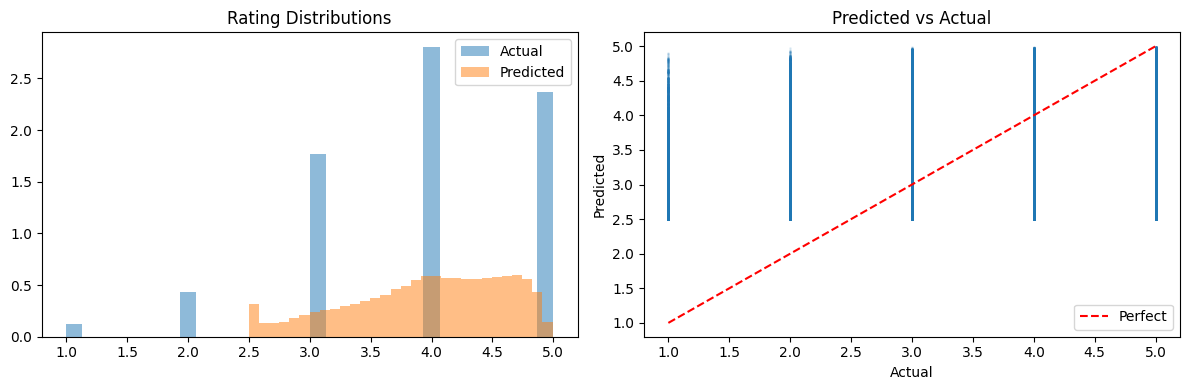

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Histogram comparison
plt.subplot(1, 2, 1)
plt.hist(results["targets"], bins=30, alpha=0.5, label="Actual", density=True)
plt.hist(results["predictions"], bins=30, alpha=0.5, label="Predicted", density=True)
plt.legend()
plt.title("Rating Distributions")

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(results["targets"], results["predictions"], alpha=0.1, s=1)
plt.plot([1, 5], [1, 5], 'r--', label="Perfect")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
class BookRecommender:
    def __init__(
        self,
        model: TwoTowerModel,
        encoder: FeatureEncoder,
        metadata_df: pl.DataFrame,
        user_features_df: pl.DataFrame,
        device: str = "cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.model = model.to(device).eval()
        self.encoder = encoder
        self.metadata_df = metadata_df
        self.device = device

        # Store user features as lookup dict
        self.user_features = self._prepare_user_features(user_features_df)

        # Pre-compute all book embeddings
        self.book_ids, self.book_embeddings = self._compute_book_embeddings()

        # Book metadata lookup
        self.book_metadata = {
            row["book_id"]: row
            for row in (metadata_df.row(i, named=True) for i in range(len(metadata_df)))
        }

    def _compute_book_embeddings(self):
        """Pre-compute embeddings for all books"""
        print("Computing book embeddings...")
        # Use your existing compute_all_book_embeddings function
        # Or create a DataLoader for books and run through book_tower

        book_ids = []
        embeddings = []

        dataset = GoodreadsDataset(
            # Create dummy interactions with all books
            pl.DataFrame({
                "user_id": ["dummy"] * len(self.metadata_df),
                "book_id": self.metadata_df["book_id"].to_list(),
                "rating": [0] * len(self.metadata_df),
                "is_read": [True] * len(self.metadata_df),
                "date_added": [""] * len(self.metadata_df),
                "date_updated": [""] * len(self.metadata_df),
                "read_at": [""] * len(self.metadata_df),
                "started_at": [""] * len(self.metadata_df),
            }),
            self.metadata_df,
            self.encoder
        )

        loader = DataLoader(dataset, batch_size=512, collate_fn=collate_fn)

        with torch.no_grad():
            for batch in tqdm(loader, desc="Book embeddings"):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                book_emb = self.model.book_tower(
                    batch["book_idx"],
                    batch["author_indices"],
                    batch["author_offsets"],
                    batch["publisher_idx"],
                    batch["format_idx"],
                    batch["shelf_indices"],
                    batch["shelf_offsets"],
                    batch["numerical"]
                )
                book_emb = F.normalize(book_emb, p=2, dim=1)
                embeddings.append(book_emb.cpu())

        embeddings = torch.cat(embeddings, dim=0)
        book_ids = self.metadata_df["book_id"].to_list()

        print(f"Computed {len(book_ids)} book embeddings")
        return book_ids, embeddings.to(self.device)


    def _prepare_user_features(self, user_features_df: pl.DataFrame) -> dict:
        """Create user_id -> features lookup"""
        feature_cols = ["num_books", "avg_rating_given", "rating_std", "min_rating", "max_rating"]  # Match your cols

        user_feats = {}
        for row in user_features_df.iter_rows(named=True):
            feats = [row.get(col) or 0 for col in feature_cols]
            user_feats[row["user_id"]] = feats

        return user_feats

    def get_user_embedding(self, user_id: str) -> torch.Tensor:
        """Get embedding for a user"""
        user_idx = torch.tensor([self.encoder.user_to_idx[user_id]], device=self.device)

        # Get actual user features
        feats = self.user_features.get(user_id, [0] * 5)  # Default to zeros if missing
        user_features = torch.tensor([feats], dtype=torch.float32, device=self.device)

        with torch.no_grad():
            user_emb = self.model.user_tower(user_idx, user_features)
            user_emb = F.normalize(user_emb, p=2, dim=1)
        return user_emb


    def recommend_diverse(
        self,
        user_id: str,
        top_k: int = 10,
        candidate_pool: int = 500,
        lambda_: float = 0.7,  # Higher = more relevance, Lower = more diversity
        exclude_book_ids: list = None,
        min_ratings: int = 500,  # Filter for books with at least this many ratings
    ) -> pl.DataFrame:
        """
        MMR-based diverse recommendations

        Args:
            user_id: Target user
            top_k: Number of recommendations to return
            candidate_pool: Initial candidates to consider (top by relevance)
            lambda_: Tradeoff parameter (0=max diversity, 1=max relevance)
            exclude_book_ids: Books to exclude (e.g., already read)
        """
        user_emb = self.get_user_embedding(user_id)

        # Step 1: Compute relevance scores for all books
        with torch.no_grad():
            relevance_scores = torch.matmul(user_emb, self.book_embeddings.T).squeeze()

        # Step 2: Exclude already-read books
        if exclude_book_ids:
            for book_id in exclude_book_ids:
                if book_id in self.encoder.book_to_idx:
                    idx = self.book_ids.index(book_id)
                    relevance_scores[idx] = -float('inf')

        if min_ratings:
          for i, book_id in enumerate(self.book_ids):
              meta = self.book_metadata.get(book_id, {})
              # ratings_count_log -> convert back: exp(x) - 1
              ratings_log = meta.get("ratings_count_log", 0)
              ratings_count = np.expm1(ratings_log)  # inverse of log1p
              if ratings_count < min_ratings:
                  relevance_scores[i] = -float('inf')

        # Step 3: Get top candidates by relevance
        top_indices = torch.topk(relevance_scores, candidate_pool).indices.cpu().numpy()
        candidate_scores = relevance_scores[top_indices].cpu().numpy()
        candidate_embeddings = self.book_embeddings[top_indices]

        # Step 4: MMR selection
        selected_indices = []
        selected_embeddings = []

        for _ in range(top_k):
            if len(selected_indices) == 0:
                # First item: pick highest relevance
                best_idx = 0
            else:
                # Compute MMR scores
                mmr_scores = []
                selected_emb_tensor = torch.stack(selected_embeddings)

                for i, (score, emb) in enumerate(zip(candidate_scores, candidate_embeddings)):
                    if i in selected_indices:
                        mmr_scores.append(-float('inf'))
                        continue

                    # Max similarity to already selected items
                    similarities = torch.matmul(emb.unsqueeze(0), selected_emb_tensor.T)
                    max_sim = similarities.max().item()

                    # MMR score
                    mmr = lambda_ * score - (1 - lambda_) * max_sim
                    mmr_scores.append(mmr)

                best_idx = np.argmax(mmr_scores)

            selected_indices.append(best_idx)
            selected_embeddings.append(candidate_embeddings[best_idx])

        # Step 5: Build results
        results = []
        for idx in selected_indices:
            book_idx = top_indices[idx]
            book_id = self.book_ids[book_idx]
            meta = self.book_metadata.get(book_id, {})

            results.append({
                "book_id": book_id,
                "relevance_score": float(candidate_scores[idx]),
                "predicted_rating": float((candidate_scores[idx] + 1) / 2 * 5),
                "title": meta.get("title", "Unknown"),
                "top_shelves": meta.get("top_shelves", []),
                "average_rating": meta.get("average_rating"),
            })

        return pl.DataFrame(results)

    def compute_diversity(self, book_ids: list) -> float:
        """Compute average pairwise distance of recommended set"""
        indices = [self.book_ids.index(bid) for bid in book_ids if bid in self.book_ids]
        embeddings = self.book_embeddings[indices]

        # Pairwise cosine similarities
        sim_matrix = torch.matmul(embeddings, embeddings.T)

        # Average off-diagonal (exclude self-similarity)
        n = len(indices)
        avg_sim = (sim_matrix.sum() - n) / (n * (n - 1))

        # Diversity = 1 - similarity
        return 1 - avg_sim.item()

In [ ]:
# Initialize recommender
recommender = BookRecommender(
    model,
    encoder,
    processed_books_df,
    user_features_df
)

# Get user's read books
user_id = train_interactions["user_id"][25]
read_books = train_interactions.filter(
    pl.col("user_id") == user_id
)["book_id"].to_list()

print(read_books)

# Compare different lambda values
print("HIGH RELEVANCE (λ=0.9):")
recs_relevant = recommender.recommend_diverse(
    user_id, top_k=10, lambda_=0.9, exclude_book_ids=read_books
)
print(recs_relevant)
print(f"Diversity: {recommender.compute_diversity(recs_relevant['book_id'].to_list()):.3f}")

print("\nBALANCED (λ=0.7):")
recs_balanced = recommender.recommend_diverse(
    user_id, top_k=10, lambda_=0.7, exclude_book_ids=read_books
)
print(recs_balanced)
print(f"Diversity: {recommender.compute_diversity(recs_balanced['book_id'].to_list()):.3f}")

print("\nHIGH DIVERSITY (λ=0.4):")
recs_diverse = recommender.recommend_diverse(
    user_id, top_k=10, lambda_=0.4, exclude_book_ids=read_books
)

recs = recommender.recommend_diverse(
    user_id,
    top_k=10,
    candidate_pool=500,  # Increase from 100
    lambda_=0.2,         # Much lower
    exclude_book_ids=read_books
)
print(recs_diverse)
print(f"Diversity: {recommender.compute_diversity(recs_diverse['book_id'].to_list()):.3f}")

NameError: name 'BookRecommender' is not defined

In [ ]:
# Check embedding variance
print(f"Embedding std per dimension: {recommender.book_embeddings.std(dim=0).mean():.4f}")
print(f"Embedding mean per dimension: {recommender.book_embeddings.mean(dim=0)[:10]}")

# Check pairwise similarity of random books
random_idx = torch.randint(0, len(recommender.book_embeddings), (100,))
random_embs = recommender.book_embeddings[random_idx]
sims = torch.matmul(random_embs, random_embs.T)
print(f"Random pair similarity - Mean: {sims.mean():.3f}, Std: {sims.std():.3f}")

Embedding std per dimension: 0.0409
Embedding mean per dimension: tensor([0.1818, 0.1208, 0.1235, 0.1088, 0.1257, 0.1099, 0.0000, 0.1595, 0.2000,
        0.0857], device='cuda:0')
Random pair similarity - Mean: 0.862, Std: 0.109
